# Lab 3: Self-Supervised Learning

In [2]:
%pip install git+https://github.com/openai/CLIP.git
%pip install pyarrow

  Cloning https://github.com/openai/CLIP.git to c:\users\gabri\appdata\local\temp\pip-req-build-tpog2udz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\gabri\AppData\Local\Temp\pip-req-build-tpog2udz'


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import io
import clip
import pyarrow as pa
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torch import nn
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms


import numpy as np
from matplotlib import pyplot as plt

from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_DEFAULT_STD,
)

CLASSES_FOOD101 = [
        "frozen yogurt", "tacos","gnocchi", "ramen", "sushi", "spaghetti carbonara", "foie gras", "club sandwich",
        "chicken curry", "caprese salad", "guacamole", "fish and chips", "seaweed salad", "samosa", "shrimp and grits",
        "prime rib", "cheese plate", "grilled cheese sandwich", "omelette", "macarons", "pancakes", "paella",
        "crab cakes", "onion rings", "poutine", "panna cotta", "hamburger", "eggs benedict", "pizza", "cup cakes",
        "red velvet cake", "huevos rancheros", "french toast", "pad thai","beef tartare", "beet salad",
        "garlic bread", "escargots", "cheesecake", "tuna tartare", "french fries", "pulled pork sandwich", "ravioli",
        "clam chowder", "baby back ribs", "pork chop", "chicken quesadilla", "grilled salmon", "dumplings",
        "fried rice", "macaroni and cheese", "hot and sour soup", "tiramisu",  "lobster_roll_sandwich",
        "filet mignon",  "lobster bisque",  "risotto",  "takoyaki",  "waffles",  "miso soup",  "scallops",
        "hummus", "french onion soup", "spaghetti bolognese", "gyoza", "sashimi", "caesar salad",
        "donuts", "pho", "creme brulee", "edamame","apple pie", "carrot cake", "croque madame",
        "chocolate_cake", "mussels", "chocolate mousse", "deviled eggs", "ice cream",
        "chicken_wings", "steak", "churros", "beignets", "breakfast burrito", "spring rolls",
        "lasagna", "cannoli", "nachos", "bruschetta", "hot dog", "greek salad", "beef carpaccio",
        "falafel", "strawberry shortcake", "bread pudding", "ceviche", "peking duck",
        "bibimbap", "oysters", "fried calamari", "baklava"
    ]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Introduction

In this lab, we will explore the principles and practical applications of self-supervised learning, first in a uni-modal setting, and then in a multimodal setting. We will focus on the SimCLR and CLIP models respectively.


### Objectives
- Exploring self-supervised learning
- Handling multimodal data  

# Part 1. Unimodal Self-Supervised Learning: SimCLR

## How SimCLR works?
SimCLR, short for Simple Framework for Contrastive Learning of Visual Representations, is a self-supervised learning method designed to train deep neural networks without labeled data. It enables models to learn meaningful visual representations by contrasting positive pairs (augmented views of the same image) against negatives. 



<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-02_at_4.31.34_PM_7zlWDQE.png" width=300>

Figure: A simple framework for contrastive learning of visual representation [Chen et al, 2020] 

In practice, SimCLR relies on:

1. Data Augmentation:
Randomly sample a minibatch $B$ of samples, and apply two different data augmentations to each sample $x$, resulting in $2N$ augmented samples: 

$\tilde{x_i}=t(x), \tilde{x_j}=t'(x), t,t' \sim T$

where $t,t'$ are two separate data augmentation operators, sampled from the same family of augmentation $T$.
Data augmentation includes random crop, resize with random flip, color distortions, and Gaussian blur.

2. Given one positive pair, other 
 data points are treated as negative samples. The representation is produced by a base encoder $f(.)$ (e.g. ResNet-18):

$h_i = f(\tilde{x_i}), h_j = f(\tilde{x_j})$

3. The contrastive learning loss is defined using cosine similarity $\text{sim}(.,.)$. The loss is computed on an projection layer of the representation  rather than on the representation space directly. The representation $h$ is used for downstream tasks.

$L_\text{simclr}^{(i,j)} = -\text{log} \frac{\text{exp}( \text{sim}(z_i, z_j)/ \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \text{exp}( \text{sim}(z_i, z_k)/ \tau)}$, $\mathbb{1}_{[k \neq i]}$ the indicator function, 1 if $k \neq i$ 0 otherwise.



For more details see: https://arxiv.org/pdf/2002.05709



Self-supervised learning (SSL) approaches for image understanding have demonstrated state-of-the-art performance across various settings. These methods are particularly effective when trained on large-scale datasets containing millions of images, enabling the learning of general-purpose representations. To gain a practical understanding of these methodologies, we will experiment with CIFAR-100, a smaller-scale dataset that simplifies the exploration of SSL concepts while preserving their core principles.

We will compare a fully-supervised baseline with a backbone pretrained using SimCLR, followed by fine-tuning. This comparison will highlight some benefits of self-supervised pretraining.

### Question 1.1
Train a fully-supervised baseline on CIFAR-100.

Use the ResNet-18 on CIFAR-100 for 20 epochs and log both train and test loss and accuracy.
Hparameters are to be choosen to your discretion.

Tips.
- Use Adam with some weight decay to avoid overfitting
- You can use data augmentation strategy to avoid overfitting on the training data
- For the normalization values you use: `(0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)`

In [4]:
def supervised_baseline(n_epochs, batch_size, lr):
    # - transformations
    train_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomCrop(32, padding=4),
            #torchvision.transforms.ColorJitter(),
            torchvision.transforms.RandomHorizontalFlip(),
            #torchvision.transforms.RandomRotation(90),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
            )
        ]
    )
    test_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
            )
        ]
    )

    # - dataset and dataloader
    trainset = torchvision.datasets.CIFAR100(root="./data", train=True, transform=train_transform, download=True)
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=4, pin_memory=True)

    testset = torchvision.datasets.CIFAR100(root="./data", train=False, transform=test_transform, download=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory=True)

    # - model
    model = torchvision.models.resnet18(pretrained=False) # load the architecture 
    model.fc = nn.Linear(model.fc.in_features, 100) # change the output layer to match the number of classes
    
    # To complete
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)

    for epoch in range(n_epochs) :
        model.train()
        train_loss, train_acc = 0.0, 0.0
        correct, total = 0,0
        for images, labels in trainloader :
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss+=loss.item()
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
        train_loss/=len(trainloader)
        train_acc=correct/total

        model.eval()
        test_acc, test_loss = 0.0, 0.0

        with torch.no_grad() :
            total = 0.0
            for images, labels in testloader :
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)

                test_loss+= loss.item()
                test_acc+= (logits.argmax(1) == labels).sum().item()
                total+=labels.size(0)
        test_loss/=len(testloader)
        test_acc/=total

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%"
        )

    

In [5]:
lr = 0.001 # Hparam to complete
batch_size = 128 # Hparam to complete
n_epochs = 20 # Hparam to complete
supervised_baseline(n_epochs=n_epochs, lr=lr, batch_size=batch_size)

c:\Users\gabri\miniconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabri\miniconda3\envs\ML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 01 | Train Loss: 3.7238 | Train Acc: 13.01% | Test Loss: 3.3746 | Test Acc: 18.67%
Epoch 02 | Train Loss: 3.1303 | Train Acc: 22.67% | Test Loss: 2.9870 | Test Acc: 26.58%
Epoch 03 | Train Loss: 2.8093 | Train Acc: 28.42% | Test Loss: 2.7184 | Test Acc: 30.57%
Epoch 04 | Train Loss: 2.5927 | Train Acc: 32.82% | Test Loss: 2.6539 | Test Acc: 32.89%
Epoch 05 | Train Loss: 2.4085 | Train Acc: 36.79% | Test Loss: 2.4221 | Test Acc: 37.11%
Epoch 06 | Train Loss: 2.2710 | Train Acc: 39.50% | Test Loss: 2.4115 | Test Acc: 37.92%
Epoch 07 | Train Loss: 2.1477 | Train Acc: 42.25% | Test Loss: 2.2862 | Test Acc: 41.07%
Epoch 08 | Train Loss: 2.0306 | Train Acc: 44.84% | Test Loss: 2.1865 | Test Acc: 43.15%
Epoch 09 | Train Loss: 1.9339 | Train Acc: 46.93% | Test Loss: 2.1794 | Test Acc: 43.35%
Epoch 10 | Train Loss: 1.8430 | Train Acc: 49.12% | Test Loss: 2.1079 | Test Acc: 44.75%
Epoch 11 | Train Loss: 1.7665 | Train Acc: 50.74% | Test Loss: 2.0297 | Test Acc: 46.61%
Epoch 12 | Train Loss

### Question 1.2
We need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a class that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class CustomTransform below.

Implement the Data Augmentation module.

In [6]:
class CustomTransform(object):
    """Custom Transform class for SimCLR"""
    def __init__(self, transform):
        """Initializes the transforms"""
        # To complete
        self.transform = transform

    def __call__(self, x):
        """Applies the two transformations to the input x
        
        __call__ method allows an instance of a class to 
        be called as if it were a function.

        Parameters
        ----------
        x: torch.Tensor
            Input image tensor to be transformed

        Returns
        -------
        x1, x2: torch.Tensor, torch.Tensor
            Transformed images
        """
        # To complete
        return self.transform(x), self.transform(x)

### Question 1.3

Plot a few pairs of transformed images from the dataset using `CustomTransform`

Tip. CIFAR-100 is a low resolution data set, thus images may appear highly pixelized.

In [7]:
base_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=32),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5,
                                contrast=0.5,
                                saturation=0.5,
                                hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
paired_transformed = CustomTransform(base_transform) # Custom transform for SimCLR
train_set = torchvision.datasets.CIFAR100(root="./data", 
                                          train=True, 
                                          transform=paired_transformed, 
                                          download=True)

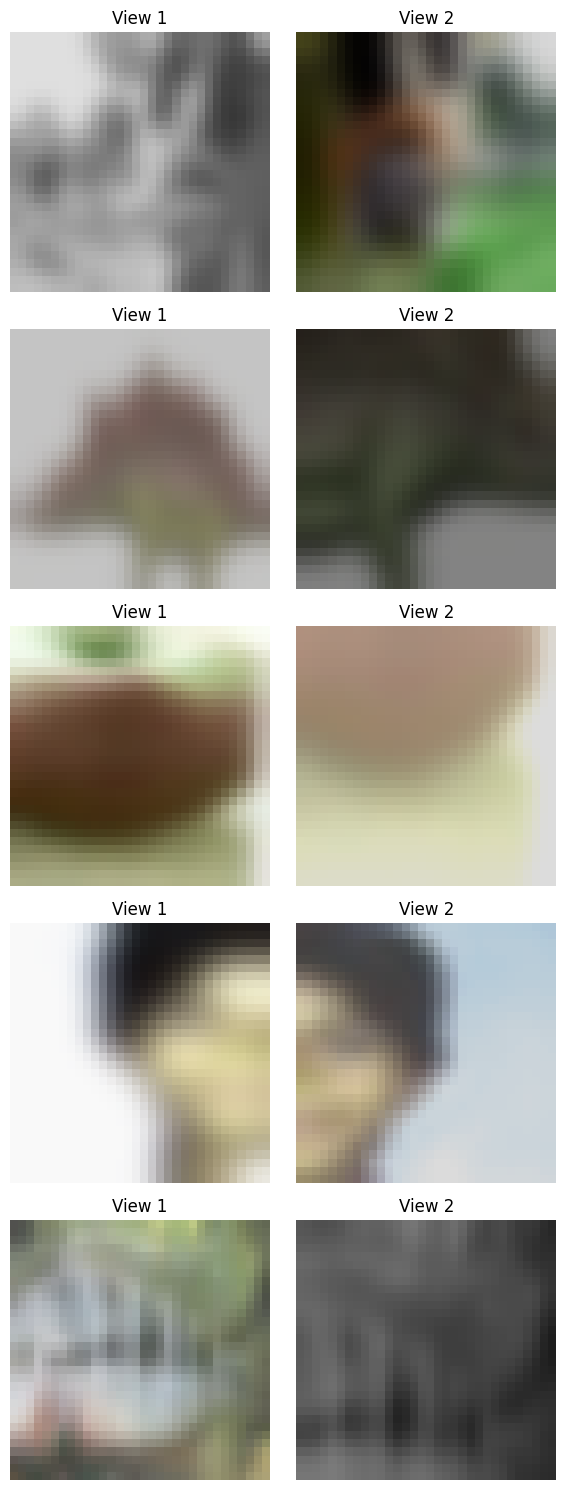

In [8]:
# to complete - plot the images
n=5
fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))

for i in range(n):
    (x1, x2), _ = train_set[i]

    # Convert tensors to numpy
    x1 = x1.permute(1, 2, 0).numpy()
    x2 = x2.permute(1, 2, 0).numpy()

    axes[i, 0].imshow(x1)
    axes[i, 0].set_title("View 1")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(x2)
    axes[i, 1].set_title("View 2")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

### Question 1.3

To implement the SimCLR architecture, we need a model composed of: 
- the backbone $f$ (e.g. ResNet-18) 
- the projection head ($g$), a two layer MLP. 
- at each forward pass, return the represention ($h = f(x)$) and the projection ($z = g(h)$)

Implement the model. 

Tip. 
- Remove the last fully connected layer from ResNet-18 (which is the classifier layer when used with ImageNet), you can do this by replacing it by `nn.Identity`

In [9]:
class SimCLRModel(nn.Module):
    def __init__(self, hidden_dim=512, projection_dim=128):
        """
        Backbone class which returns the hidden representation h and the projection z

        Parameters:
        -----------
        hidden_dim: int
            The hidden dimension of the projector. Default is 512
        projection_dim: int
            The dimension of the output features after projection. Default is 128
        """
        super(SimCLRModel, self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=False)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.proj_head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )
        # to complete

    def forward(self, x):
        """Forward pass
        
        Parameters:
        -----------
        x: torch.Tensor
            The input tensor
        """
        # to complete 
        h = self.backbone(x)
        z = self.proj_head(h)
        return h, z

### Question 1.4 
Implement the constrastive loss as mentionned in the introduction paragraph of SimCLR.

Tip.
You can first compute the 2N×2N matrix (both dimensions contain all augmented views) and then deduce the numerator and denominator by extracting the positives and negatives pairs.


Illustration of the similarity matrix for a batch size $N=2$:
| Views  | View1A | View1B | View2A | View2B |
|--------|--------|--------|--------|--------|
| View1A | -      | ✓      | ✗      | ✗      |
| View1B | ✓      | -      | ✗      | ✗      |
| View2A | ✗      | ✗      | -      | ✓      |
| View2B | ✗      | ✗      | ✓      | -      |


- The similarity matrix is (2N)×(2N) where N is your batch size (because each sample has 2 augmented views)
- Positive pairs (✓): Off-diagonal elements where View[i] A matches with View[i] B
These are different augmentations of the same original image
- Negative pairs (✗): All other off-diagonal elements
- Diagonal elements (-): Removed because they represent self-similarity


In [10]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """
    
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        # to complete
        self.batch_size = batch_size
        self.temperature = temperature

    def forward(self, proj_i, proj_j):
        """
        Computes the contrastive loss with z_i and z_j

        Parameters:
        -----------

        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        # to complete
        z = torch.cat([proj_i, proj_j], dim=0)
        z = F.normalize(z, dim=1)

        sim = torch.matmul(z, z.T) / self.temperature
        mask = (~torch.eye(2*self.batch_size, device=z.device, dtype=bool)).float()
        exp_sim = torch.exp(sim) * mask

        denom = exp_sim.sum(dim=1, keepdim=True)

        positives = torch.exp(F.cosine_similarity(proj_i, proj_j) / self.temperature)
        numerator = torch.cat([positives, positives], dim=0).unsqueeze(1)

        loss = - torch.log(numerator/(denom+ 1e-8))

        return loss.mean()


### Question 1.5
Train the `SimCLRModel` on the CIFAR-100 dataset using the `ContrastiveLoss` for 100 epochs (for compute reason you can use only **10 epochs**) and log train losses.
Hyperparameters are to be choosen to your discretion.

Tips.
- You can use the `torch.optim.Adam` with weight decay
- You can set the temperature in `ContrastiveLoss` to 0.5

Training takes around 30min (depending of hparams), so keep working on the next questions while it trains. You can copy paste the notebook and run it in a separate collab instance to be able to execute the code of the next questions.

In [11]:
def unsupervised_training(device, lr,  n_epochs, batch_size):
    """Unsupervised training using SimCLR framework
    
    Parameters
    ----------
    device: str
        The device to use for training
    lr: float
        The learning rate
    n_epochs: int
        The number of epochs to train for

    Returns
    -------
    model: nn.Module
        the trained model
    """
    # - Create the model
    model = SimCLRModel(hidden_dim=512, projection_dim=128).to(device)

    # - Data
    base_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=32),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.5,
                                    contrast=0.5,
                                    saturation=0.5,
                                    hue=0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    train_set = torchvision.datasets.CIFAR100(root="./data", 
                                              train=True, 
                                              transform=CustomTransform(base_transform), 
                                              download=True)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print(f"Starting training on {device}...")
    # To complete
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = ContrastiveLoss(batch_size)

    for epoch in range(n_epochs) :
        model.train()
        train_loss = 0.0
        for images, _ in train_loader :
            x_i, x_j = images
            x_i, x_j = x_i.to(device), x_j.to(device)

            optimizer.zero_grad()
            (_, proj_i), (_, proj_j) = model(x_i), model(x_j)
            loss = criterion(proj_i, proj_j)
            
            loss.backward()
            optimizer.step()

            train_loss+=loss.item()
        
        train_loss/=len(train_loader)

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss:.4f} | "
        )
    
    
    return model

In [12]:
batch_size = 64 # Hparam to complete
lr = 1e-3 # Hparam to complete
n_epochs = 10 # Hparam to complete

model = unsupervised_training(device=device, lr=lr, n_epochs=10, batch_size=batch_size)

Starting training on cuda:0...
Epoch 01 | Train Loss: 4.1502 | 
Epoch 02 | Train Loss: 3.9884 | 
Epoch 03 | Train Loss: 3.9461 | 
Epoch 04 | Train Loss: 3.9075 | 
Epoch 05 | Train Loss: 3.8802 | 
Epoch 06 | Train Loss: 3.8549 | 
Epoch 07 | Train Loss: 3.8360 | 
Epoch 08 | Train Loss: 3.8198 | 
Epoch 09 | Train Loss: 3.8150 | 
Epoch 10 | Train Loss: 3.8056 | 


### Question 1.6 

Now that the model has been pretrained, let's finetune it on the downstream task: classification.

Add a linear classifier on top of the representation and train all (both the backbone from the SimCLR model: the Resnet-18 pretrained and the linear classifier) on CIFAR-100 for 20 epochs using `CrossEntropyLoss`  and log both train and test loss and accuracies.
The model should converge faster than when trained in a full-supervised way, and achieve a better accuracy.

Hparameters are to be choosen to your discretion.

In [13]:
class LinearEvaluation (nn.Module) :
    def __init__(self, model, n_classes) :
        super().__init__()
        self.simclr = model
        self.simclr.proj_head = nn.Identity() 
        self.simclr.linear_eval = True
        
        self.linear = nn.Linear(512, n_classes)
    
    def forward(self, x) :
        h, _ = self.simclr(x)
        pred = self.linear(h)
        return pred

def supervised_training(simclr_model, 
                    n_classes, 
                    n_epochs, 
                    lr, 
                    device,
                    batch_size):
    """Supervised training using the features learned by SimCLR"""
    # - data
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
    ])
    trainset = torchvision.datasets.CIFAR100(root="./data", train=True, transform=train_transform, download=True)
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)

    testset = torchvision.datasets.CIFAR100(root="./data", train=False, transform=test_transform, download=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

    # to complete

    model = LinearEvaluation(simclr_model, n_classes).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = preds.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
            

        train_acc = 100. * correct_train / total_train
        avg_train_loss = train_loss / len(trainloader)

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in tqdm(testloader, desc=f"Epoch {epoch+1}/{n_epochs} [Test] "):
                images, labels = images.to(device), labels.to(device)
                preds = model(images)
                loss = criterion(preds, labels)

                test_loss += loss.item()
                _, predicted = preds.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()

        test_acc = 100. * correct_test / total_test
        avg_test_loss = test_loss / len(testloader)

        print(f"\nResult Epoch {epoch+1}:")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Test Loss:  {avg_test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
        print("-" * 50)

    print("Fine-tuning complete.")
    return model

    

In [14]:
lr = 1e-3 # Hparam to complete
batch_size = 128 # Hparam to complete
model_trained = supervised_training(model, device=device, n_classes=100, n_epochs=20, lr=lr, batch_size=batch_size)

Epoch 1/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.40it/s]



Result Epoch 1:
Train Loss: 3.6291 | Train Acc: 14.19%
Test Loss:  3.2677 | Test Acc:  19.54%
--------------------------------------------------


Epoch 2/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.72it/s]



Result Epoch 2:
Train Loss: 3.1409 | Train Acc: 22.01%
Test Loss:  2.9549 | Test Acc:  26.03%
--------------------------------------------------


Epoch 3/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.60it/s]



Result Epoch 3:
Train Loss: 2.8448 | Train Acc: 27.65%
Test Loss:  2.7564 | Test Acc:  29.63%
--------------------------------------------------


Epoch 4/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.68it/s]



Result Epoch 4:
Train Loss: 2.6282 | Train Acc: 32.06%
Test Loss:  2.5993 | Test Acc:  33.13%
--------------------------------------------------


Epoch 5/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.38it/s]



Result Epoch 5:
Train Loss: 2.4795 | Train Acc: 34.94%
Test Loss:  2.4366 | Test Acc:  37.26%
--------------------------------------------------


Epoch 6/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.38it/s]



Result Epoch 6:
Train Loss: 2.3518 | Train Acc: 37.80%
Test Loss:  2.3620 | Test Acc:  38.44%
--------------------------------------------------


Epoch 7/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.45it/s]



Result Epoch 7:
Train Loss: 2.2309 | Train Acc: 40.23%
Test Loss:  2.2824 | Test Acc:  40.42%
--------------------------------------------------


Epoch 8/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.60it/s]



Result Epoch 8:
Train Loss: 2.1337 | Train Acc: 42.38%
Test Loss:  2.1940 | Test Acc:  42.48%
--------------------------------------------------


Epoch 9/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.54it/s]



Result Epoch 9:
Train Loss: 2.0436 | Train Acc: 44.54%
Test Loss:  2.1792 | Test Acc:  42.81%
--------------------------------------------------


Epoch 10/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.48it/s]



Result Epoch 10:
Train Loss: 1.9583 | Train Acc: 46.68%
Test Loss:  2.0990 | Test Acc:  44.75%
--------------------------------------------------


Epoch 11/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.46it/s]



Result Epoch 11:
Train Loss: 1.8907 | Train Acc: 47.56%
Test Loss:  2.0630 | Test Acc:  45.60%
--------------------------------------------------


Epoch 12/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.30it/s]



Result Epoch 12:
Train Loss: 1.8130 | Train Acc: 49.82%
Test Loss:  2.0192 | Test Acc:  46.69%
--------------------------------------------------


Epoch 13/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.32it/s]



Result Epoch 13:
Train Loss: 1.7500 | Train Acc: 51.30%
Test Loss:  2.0152 | Test Acc:  47.13%
--------------------------------------------------


Epoch 14/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.51it/s]



Result Epoch 14:
Train Loss: 1.6808 | Train Acc: 52.90%
Test Loss:  2.0168 | Test Acc:  47.12%
--------------------------------------------------


Epoch 15/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.40it/s]



Result Epoch 15:
Train Loss: 1.6223 | Train Acc: 54.20%
Test Loss:  2.0144 | Test Acc:  47.94%
--------------------------------------------------


Epoch 16/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.48it/s]



Result Epoch 16:
Train Loss: 1.5660 | Train Acc: 55.52%
Test Loss:  1.9690 | Test Acc:  48.33%
--------------------------------------------------


Epoch 17/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.68it/s]



Result Epoch 17:
Train Loss: 1.5072 | Train Acc: 56.90%
Test Loss:  1.9793 | Test Acc:  49.09%
--------------------------------------------------


Epoch 18/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.61it/s]



Result Epoch 18:
Train Loss: 1.4533 | Train Acc: 58.03%
Test Loss:  1.9787 | Test Acc:  49.42%
--------------------------------------------------


Epoch 19/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.40it/s]



Result Epoch 19:
Train Loss: 1.3915 | Train Acc: 59.77%
Test Loss:  1.9435 | Test Acc:  50.34%
--------------------------------------------------


Epoch 20/20 [Test] : 100%|██████████| 79/79 [00:05<00:00, 15.41it/s]


Result Epoch 20:
Train Loss: 1.3473 | Train Acc: 60.78%
Test Loss:  1.9772 | Test Acc:  50.21%
--------------------------------------------------
Fine-tuning complete.


# Part 2. Multimodal Self-Supervised Learning: CLIP

## How CLIP works?

CLIP learns the relationship between an image and a sentence (its caption). Once trained, the model can retrieve the most relevant images for a given sentence. Unlike traditional models trained on single labels like "airplane" or "bird," CLIP leverages full sentences. This allows the model to capture richer patterns and relationships between text and images. A key factor in CLIP’s success was its training on a massive dataset of image-text pairs. This diverse dataset enables the model to generalize well across various concepts, enhancing its ability to understand and link complex relationships between visual and textual information. Additionally, when trained on a large dataset of images and their corresponding textual descriptions, CLIP can also function as a zero-shot classifier.

For more details: https://arxiv.org/pdf/2103.00020

<img src="https://jumdc.github.io/assets/img/clip.png" width=768>


### CLIP loss
CLIP loss matches images with their corresponding text descriptions, it computes similarities between all possible image-text pairs.

Formally, let $f_I^i$ and $f_T^i$ be the image feature and text feature of the $i$-th sample respectively.

The loss can be defined as: $L_{I,T} = -\sum_{i=1}^B \log \frac{\exp(\cos(f^i_I ,f^i_T)/\tau)}{\sum_{k=1}^{B}\exp(\cos(f^i_I,f^k_T)/\tau)}$, where $\tau$ is a temperature parameter $\tau \in \mathbb{R}^{+}$, $\cos(.,.)$ the cosine similarity, and $B$ the batch size.

In practise, we use the symmetric loss: $L = 0.5 * (L_{I,T} + L_{T,I})$

### Question 2.1

Implement the dataset class for UPMC-Food101 dataset.
For this, you will need to:
- Download the data [here](https://drive.google.com/file/d/1KT9Agi0rbGb8x8hRLl6ED1cCqCcKtBkS/view?usp=sharing)
- Split it in train, val, test sets using the following ratios: 0.7, 0.1, 0.2.
- Create a dataset class inherited from `torch.utils.data.Dataset` that loads the data, and preprocesses it. 

Tips: 
1. In `PyTorch`, the dataset class should inherint from [`torch.utils.data.Dataset`](https://pytorch.org/tutorials/beginner/data_loading_tutorial#dataset-class) and always override:
- `__len__`: so that `len(dataset)` returns the size of the dataset.
- `__getitem__`: to support the indexing such that `dataset[i]` can be used to get the `i`-th sample.


2. If you use colab, to ease the access to the data, you can mount your google drive and access the data from there.
- *Mount your Google Drive* to allow Colab to access files in your Drive.
```python
from google.colab import drive
drive.mount('/content/drive')
```
- Access the [file](https://drive.google.com/file/d/1KT9Agi0rbGb8x8hRLl6ED1cCqCcKtBkS/view?usp=sharing) with the data, this will automatically add it to your 'shared folder'
- Locate the Shared Folder which is tipically stored under My Drive > Shared with me. (However, only items in "My Drive" or folders you’ve added to your Drive can be accessed directly.)
- Add the Shared Folder to 'My Drive'. Drag & drop the folder in 'My Drive' folder.
- The folder with the data should now be in My Drive/LabeledDB_new
- It should now be located in the path '/content/drive/My Drive/food101.arrow'

In [15]:
DATA_DIR = "C:/Users/gabri/OneDrive/Polytechnique/3ème année/Advanced Deep Learning/Lab 3/data" # TODO: Change this to your data path

In [16]:
"""Indications and snippet to extract the data from the arrow file.

The dataset is stored as a pyarrow (an Apache format), you can use the `open_arrow` function below to retrive the data.

And the following snippet to open an image:
```python
image_bytes = io.BytesIO(table[image_key][index].as_py())
image_bytes.seek(0)
image = Image.open(image_bytes).convert("RGB")
```
"""

def open_arrow(data_dir, name):
    """Open an arrow file and returns the images, texts and labels as lists.

    Parameters
    ----------
    data_dir : str
        The directory where the arrow file is stored.
    name : str
        The name of the arrow file.
    
    Returns
    -------
    all_texts : list
        The list of texts.
    all_images : list
        The list of images in bytes.
    all_labels : list
        The list of labels.
    """
    path = os.path.join(data_dir, f"{name}.arrow")
    assert os.path.isfile(path)
    table = pa.ipc.RecordBatchFileReader(
        pa.memory_map(path, "r")
    ).read_all()
    all_texts = table["text"].to_pandas().to_list()
    all_texts = [text[0] for text in all_texts]
    all_images = table["image"].to_pandas().to_list()
    all_labels = table["label"].to_pandas().to_list()
    return all_texts, all_images, all_labels

In [17]:
import random
class MultimodalDataset(torch.utils.data.Dataset):
    """Food101 dataset."""

    def __init__(
        self,
        path: str,
        name: str, 
        split: str = None,
        img_transforms = None,
    ) -> None:
        """Initialize Food101 dataset.

        Parameters
        ----------
        path : str
            Path where the dataset is stored.
        name: str
            Name of the file to load.
        split : str, optional
            Split to use, by default None.
        img_transforms : torchvision.transforms, optional
            Image transformations, by default None.
        split : str, optional
            split to use, e.g. "train", "val", "test".
        """
        super().__init__()
        assert split in {None, "train", "val", "test"}
        self.texts, self.images, self.labels = open_arrow(path, name)
        if split is not None:
            self._apply_split(split, 42)
        self.img_transfroms = img_transforms

    def _apply_split(self, split, seed):
        n = len(self.labels)

        indices = list(range(n))
        random.seed(seed)
        random.shuffle(indices)

        train_end = int(0.7 * n)
        val_end = int(0.8 * n)

        if split == "train":
            selected = indices[:train_end]
        elif split == "val":
            selected = indices[train_end:val_end]
        else:  # test
            selected = indices[val_end:]

        self.texts = [self.texts[i] for i in selected]
        self.images = [self.images[i] for i in selected]
        self.labels = [self.labels[i] for i in selected]

    def __len__(self):
        """Len of the dataset."""
        # To complete
        return len(self.labels)

    def __getitem__(self, index):
        """Get one item from the dataset of the given index.
        
        Parameters
        ----------
        index : int
            Index of the item to get.
        """
        # To complete
        image_bytes = self.images[index]
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        if self.img_transfroms :
            image = self.img_transfroms(image)
        
        text = self.texts[index]
        label = self.labels[index]

        return image, text, label
      

### Question 2.2 
Plot a few images from the test split of the dataset along with their respective caption and label.

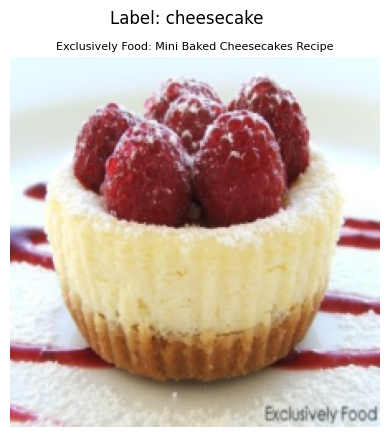

In [18]:
im_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ])
idx = 2
dataset = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="test",
                            img_transforms=im_transforms,)
# - display one image
image, text_value, labels  = dataset[idx]
plt.imshow(image.numpy().transpose(1, 2, 0))
plt.suptitle(f'Label: {CLASSES_FOOD101[labels]}')
plt.title(text_value, fontsize=8)
plt.axis('off')
plt.show()

CLIP enables **zero-shot prediction**: the model can generalize to unseen datasets without explicitly training on them. Indeed, CLIP is pre-trained to determine whether an image and a text snippet form a matching pair within its dataset. This capability is repurposed for zero-shot classification. For a given dataset, the class names can be used as potential text pairings. CLIP predicts the most likely (image, text) pair by leveraging its pretrained alignment mechanism (see (3) in the figure above). Specifically, the image and text encoders generate feature embeddings for the image and the set of class names, respectively. The cosine similarity between these embeddings is calculated, scaled by a temperature parameter ($\tau$), and converted into a probability distribution using the softmax function.

### Question 2.3

Evaluate the zero-shot performance of the CLIP model on the UPMC-Food101 dataset. Use `clip.tokenize(text_labels)` to tokenize the text labels.

In [19]:
model = clip.load("ViT-B/32", device=device)[0]
model.eval()
img_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
        ),
    ])

test_set_food = MultimodalDataset(path=DATA_DIR,
                            name="food101",
                            split="test",
                            img_transforms=img_transforms)
test_loader_food = torch.utils.data.DataLoader(test_set_food, batch_size=128, shuffle=False)

CLASSES_FOOD101 = [
        "frozen yogurt", "tacos","gnocchi", "ramen", "sushi", "spaghetti carbonara", "foie gras", "club sandwich",
        "chicken curry", "caprese salad", "guacamole", "fish and chips", "seaweed salad", "samosa", "shrimp and grits",
        "prime rib", "cheese plate", "grilled cheese sandwich", "omelette", "macarons", "pancakes", "paella",
        "crab cakes", "onion rings", "poutine", "panna cotta", "hamburger", "eggs benedict", "pizza", "cup cakes",
        "red velvet cake", "huevos rancheros", "french toast", "pad thai","beef tartare", "beet salad",
        "garlic bread", "escargots", "cheesecake", "tuna tartare", "french fries", "pulled pork sandwich", "ravioli",
        "clam chowder", "baby back ribs", "pork chop", "chicken quesadilla", "grilled salmon", "dumplings",
        "fried rice", "macaroni and cheese", "hot and sour soup", "tiramisu",  "lobster_roll_sandwich",
        "filet mignon",  "lobster bisque",  "risotto",  "takoyaki",  "waffles",  "miso soup",  "scallops",
        "hummus", "french onion soup", "spaghetti bolognese", "gyoza", "sashimi", "caesar salad",
        "donuts", "pho", "creme brulee", "edamame","apple pie", "carrot cake", "croque madame",
        "chocolate_cake", "mussels", "chocolate mousse", "deviled eggs", "ice cream",
        "chicken_wings", "steak", "churros", "beignets", "breakfast burrito", "spring rolls",
        "lasagna", "cannoli", "nachos", "bruschetta", "hot dog", "greek salad", "beef carpaccio",
        "falafel", "strawberry shortcake", "bread pudding", "ceviche", "peking duck",
        "bibimbap", "oysters", "fried calamari", "baklava"
    ]

correct = 0
total = 0

text_inputs = torch.cat([clip.tokenize(f"This is a photo of {c}") for c in CLASSES_FOOD101]).to(device)
text_features = model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)

for images, _, labels in test_loader_food :
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        logits_per_image = image_features @ text_features.t()

        predicted_labels = logits_per_image.argmax(dim=1)
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)
val_acc = correct / total
print(f"Test Acc: {val_acc:.3f}")
# To complete

Test Acc: 0.617


CLIP is composed of four main components: 
- Vision encoder 
- Text encoder
- A text and a visual projection heads to project the representations in the same space 

#### Question 2.4 
Finetune the text and image projection heads of CLIP using the UPMC-Food101 with the CLIP objective (as mentionned in the section introduction) between the image-text pairs for 100 epochs (for compute reason you can use only 5 to 10 epochs). Log both train and val losses.

Hparameters are to be choosen to your discretion.

Tips:
- You can use `torch.optim.SGD` for the optimizer
- You can use `model.visual.proj` and `model.text_projection` to access the projection heads of the model.
- For the loss, in CLIP, the similarity matrix between images and texts can be viewed as a classification problem:


**Illustration** for a batch size N=4:

| Text/Image | Img1 | Img2 | Img3 | Img4 |
|------------|------|------|------|------|
| Text1      | ✓    | ✗    | ✗    | ✗    |
| Text2      | ✗    | ✓    | ✗    | ✗    |
| Text3      | ✗    | ✗    | ✓    | ✗    |
| Text4      | ✗    | ✗    | ✗    | ✓    |

Think of each row as a text trying to "classify" which image it belongs to:

- Each text should pick its corresponding image (diagonal elements)
- The similarity scores can be treated as logits (pre-softmax probabilities)
- The "correct class" for Text1 is Img1, for Text2 is Img2, etc.

Thus, you can use the `CrossEntropyLoss` between your logits (as similarity scores) and the 'correct class'.

In [22]:
def finetune_clip(n_epochs, classes, batch_size, lr):
    """finetuning clip"""
    train_losses, val_losses = [], []
    model, _ = clip.load("ViT-B/32", device=device)
    model = model.float()
    # - Data
    im_transforms_train = torchvision.transforms.Compose(
        [transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop but keep most of food visible
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(15),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            IMAGENET_DEFAULT_MEAN,
            IMAGENET_DEFAULT_STD
        ), ]
        )
    im_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
        ),
    ])
    dataset = MultimodalDataset(path=DATA_DIR, 
                            name="food101", 
                            split="train", 
                            img_transforms=im_transforms_train)
    test_dataset = MultimodalDataset(path=DATA_DIR, 
                            name="food101", 
                            split="test", 
                            img_transforms=im_transforms)
    val_dataset = MultimodalDataset(path=DATA_DIR,
                                    name="food101",
                                    split="val",
                                    img_transforms=im_transforms)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True,
                                            drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                drop_last=False)
    test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                  batch_size=batch_size, 
                                                  shuffle=False, 
                                                  drop_last=False)
    
    for p in model.parameters():
        p.requires_grad = False

    model.visual.proj.requires_grad = True
    model.text_projection.requires_grad = True

    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    text_inputs = torch.cat([clip.tokenize(f"This is a photo of {c}") for c in classes]).to(device)

    for epoch in range(n_epochs) :

        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, _, labels in dataloader :
            images, labels = images.to(device), labels.to(device)

            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            text_features = model.encode_text(text_inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            logit_scale = model.logit_scale.exp()
            logits = logit_scale * image_features @ text_features.t()
            loss = criterion(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
        avg_train_loss = train_loss / len(dataloader)
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad() :
            text_features_val = model.encode_text(text_inputs)
            text_features_val = text_features_val / text_features_val.norm(dim=-1, keepdim=True)

            for images, _, labels in val_dataloader :
                images, labels = images.to(device), labels.to(device)

                image_features = model.encode_image(images)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)

                logit_scale = model.logit_scale.exp()
                logits = logit_scale * image_features @ text_features_val.t()

                loss = criterion(logits, labels)
                val_loss += loss.item()
                val_correct += (logits.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        avg_val_loss = val_loss / len(val_dataloader)
        val_acc = val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
            f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%"
        )
    
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        text_features_test = model.encode_text(text_inputs)
        text_features_test /= text_features_test.norm(dim=-1, keepdim=True)

        for images, _, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
            # Dot product similarity
            logits = 100.0 * image_features @ text_features_test.t()
            
            test_correct += (logits.argmax(1) == labels).sum().item()
            test_total += labels.size(0)

    print(f"Test Accuracy: {test_correct / test_total:.4f}")

    return model, train_losses, val_losses

Epoch 01 | Train Loss: 1.6670 | Train Acc: 61.24% | Val Loss: 1.5170 | Val Acc: 63.10%
Epoch 02 | Train Loss: 1.5648 | Train Acc: 62.49% | Val Loss: 1.4774 | Val Acc: 64.51%
Epoch 03 | Train Loss: 1.4939 | Train Acc: 64.23% | Val Loss: 1.4437 | Val Acc: 65.08%
Epoch 04 | Train Loss: 1.4637 | Train Acc: 64.76% | Val Loss: 1.4342 | Val Acc: 65.61%
Epoch 05 | Train Loss: 1.4191 | Train Acc: 65.73% | Val Loss: 1.4529 | Val Acc: 64.86%
Epoch 06 | Train Loss: 1.3958 | Train Acc: 66.17% | Val Loss: 1.4189 | Val Acc: 66.09%
Epoch 07 | Train Loss: 1.3686 | Train Acc: 66.39% | Val Loss: 1.3996 | Val Acc: 66.09%
Epoch 08 | Train Loss: 1.3444 | Train Acc: 66.95% | Val Loss: 1.3904 | Val Acc: 66.14%
Epoch 09 | Train Loss: 1.3078 | Train Acc: 67.95% | Val Loss: 1.3821 | Val Acc: 67.02%
Epoch 10 | Train Loss: 1.2920 | Train Acc: 68.20% | Val Loss: 1.3872 | Val Acc: 66.80%
Test Accuracy: 0.6868


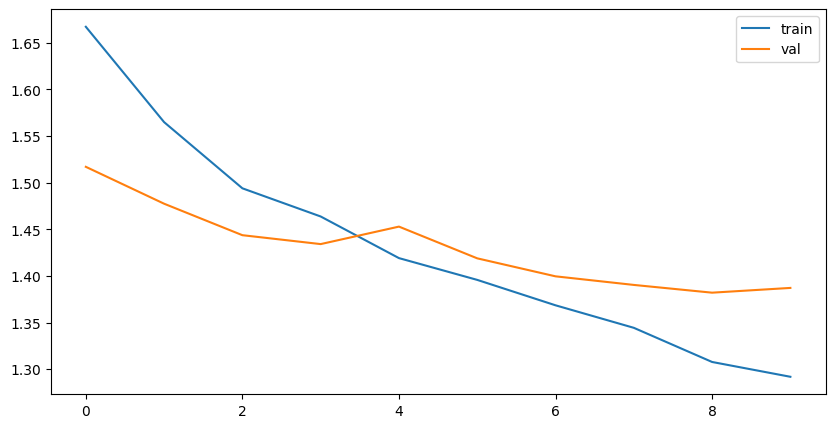

In [23]:
lr = 1e-3 # Hparams to complete
batch_size = 128 # Hparams to complete
n_epochs = 10 # Hparams to complete
model, train_losses, val_losses = finetune_clip(n_epochs=n_epochs, lr=lr, classes=CLASSES_FOOD101, batch_size=batch_size)

# - Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()